In [1]:
import os
os.environ['JAVA_TOOL_OPTIONS'] = '-Djava.security.manager=allow'

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, VectorAssembler
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import *

In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("FlightDelaysAnalysis") \
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
    .getOrCreate()

Picked up JAVA_TOOL_OPTIONS: -Djava.security.manager=allow
Picked up JAVA_TOOL_OPTIONS: -Djava.security.manager=allow
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/02 15:17:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Попробуем найти публичный URL к датасету
import requests

# Публичные URL для тестирования (примеры)
public_datasets = {
    "flight_delays": "https://raw.githubusercontent.com/databricks/Spark-The-Definitive-Guide/master/data/flight-data/csv/2015-summary.csv",
    "titanic": "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv",
    "iris": "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
}

def download_public_dataset(url, local_filename):
    """Скачивает публичный датасет"""
    try:
        response = requests.get(url)
        with open(local_filename, 'wb') as f:
            f.write(response.content)
        print(f"Датасет скачан: {local_filename}")
        return True
    except Exception as e:
        print(f"Ошибка: {e}")
        return False

# Скачиваем пример датасета
if download_public_dataset(public_datasets["flight_delays"], "flight_data.csv"):
    df = spark.read.csv("flight_data.csv", inferSchema=True, header=True)
    print("Flight data загружен:")


Датасет скачан: flight_data.csv
Flight data загружен:


In [5]:
df.show(10)
df.printSchema()

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
|    United States|          Singapore|    1|
|    United States|            Grenada|   62|
|       Costa Rica|      United States|  588|
|          Senegal|      United States|   40|
|          Moldova|      United States|    1|
+-----------------+-------------------+-----+
only showing top 10 rows
root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: integer (nullable = true)



In [6]:
df.select('DEST_COUNTRY_NAME').distinct().show()

+--------------------+
|   DEST_COUNTRY_NAME|
+--------------------+
|            Anguilla|
|              Russia|
|            Paraguay|
|             Senegal|
|              Sweden|
|            Kiribati|
|              Guyana|
|         Philippines|
|            Djibouti|
|            Malaysia|
|           Singapore|
|                Fiji|
|              Turkey|
|                Iraq|
|             Germany|
|              Jordan|
|               Palau|
|Turks and Caicos ...|
|              France|
|              Greece|
+--------------------+
only showing top 20 rows


In [7]:
df.select('ORIGIN_COUNTRY_NAME').distinct().show()

+--------------------+
| ORIGIN_COUNTRY_NAME|
+--------------------+
|            Paraguay|
|              Russia|
|            Anguilla|
|             Senegal|
|              Sweden|
|            Kiribati|
|              Guyana|
|         Philippines|
|           Singapore|
|            Malaysia|
|                Fiji|
|              Turkey|
|             Germany|
|              Jordan|
|               Palau|
|Turks and Caicos ...|
|              France|
|              Greece|
|British Virgin Is...|
|              Taiwan|
+--------------------+
only showing top 20 rows


In [8]:
df.select('count').distinct().show()

+-----+
|count|
+-----+
|   31|
| 2025|
|  588|
|   53|
|  853|
|  362|
| 1468|
|  155|
|  108|
|  211|
|   34|
|  193|
|  126|
|  115|
|  772|
|   28|
|  183|
| 1496|
|  300|
|  332|
+-----+
only showing top 20 rows


In [9]:
df.select("count").describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|               256|
|   mean|       1770.765625|
| stddev|23126.516918551915|
|    min|                 1|
|    max|            370002|
+-------+------------------+



In [12]:
df_sorted = df.orderBy(col("count").desc())
top_10 = df_sorted.limit(10)
top_10.show(truncate=False)

+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count |
+-----------------+-------------------+------+
|United States    |United States      |370002|
|United States    |Canada             |8483  |
|Canada           |United States      |8399  |
|United States    |Mexico             |7187  |
|Mexico           |United States      |7140  |
|United Kingdom   |United States      |2025  |
|United States    |United Kingdom     |1970  |
|Japan            |United States      |1548  |
|United States    |Japan              |1496  |
|Germany          |United States      |1468  |
+-----------------+-------------------+------+



In [11]:
# Общее количество рейсов
total_flights = df.agg({"count": "sum"}).collect()[0][0]
total_flights

453316

In [13]:
# Среднее количество рейсов на маршрут
avg_flights = df.agg({"count": "avg"}).collect()[0][0]
avg_flights

1770.765625

In [14]:
# Медиана
median = df.approxQuantile("count", [0.5], 0.01)[0]
median

62.0

In [15]:
# Количество уникальных маршрутов
unique_routes = df.count()
unique_routes

256

In [72]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.feature import IndexToString
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql.functions import concat, lit
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

In [17]:
# Создаем целевую переменную: популярный маршрут (count > 50)
df = df.withColumn("label", when(col("count") > 50, 1).otherwise(0))

In [29]:
# Создаем текстовую фичу для NLP
df = df.withColumn("route_text", concat(col("ORIGIN_COUNTRY_NAME"), lit(" to "), col("DEST_COUNTRY_NAME")))

In [25]:
df.show(10, truncate=False)

print("\nРаспределение классов:")
df.groupBy("label").count().show()

+-----------------+-------------------+-----+-----+---------------------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|label|route_text                 |
+-----------------+-------------------+-----+-----+---------------------------+
|United States    |Romania            |15   |0    |Romania to United States   |
|United States    |Croatia            |1    |0    |Croatia to United States   |
|United States    |Ireland            |344  |1    |Ireland to United States   |
|Egypt            |United States      |15   |0    |United States to Egypt     |
|United States    |India              |62   |1    |India to United States     |
|United States    |Singapore          |1    |0    |Singapore to United States |
|United States    |Grenada            |62   |1    |Grenada to United States   |
|Costa Rica       |United States      |588  |1    |United States to Costa Rica|
|Senegal          |United States      |40   |0    |United States to Senegal   |
|Moldova          |United States      |1

In [37]:
# Нужно сначала отдельно обучить StringIndexer на всех данных, чтобы он знал все возможные значения
# так как встречаются разные страны
all_countries = df.select("ORIGIN_COUNTRY_NAME").union(df.select("DEST_COUNTRY_NAME")).distinct()
print(f"Всего уникальных стран в данных: {all_countries.count()}")

Всего уникальных стран в данных: 138


In [61]:
# Создаем StringIndexer с handleInvalid='keep'
indexer_origin_fixed = StringIndexer(inputCol="ORIGIN_COUNTRY_NAME", outputCol="origin_index", handleInvalid="keep")
indexer_dest_fixed = StringIndexer(inputCol="DEST_COUNTRY_NAME", outputCol="dest_index", handleInvalid="keep")

In [62]:
# Обучаем StringIndexer на ВСЕХ данных, чтобы знать все категории
indexer_origin_model = indexer_origin_fixed.fit(df)
indexer_dest_model = indexer_dest_fixed.fit(df)

In [64]:
# Применяем к данным
train_data_indexed = indexer_origin_model.transform(train_data_raw)
train_data_indexed = indexer_dest_model.transform(train_data_indexed)

test_data_indexed = indexer_origin_model.transform(test_data_raw)
test_data_indexed = indexer_dest_model.transform(test_data_indexed)

In [65]:
# Подсчитываем уникальные значения
n_unique_origin = train_data_indexed.select("origin_index").distinct().count()
n_unique_dest = train_data_indexed.select("dest_index").distinct().count()

print(f"Уникальных значений origin_index: {n_unique_origin}")
print(f"Уникальных значений dest_index: {n_unique_dest}")

Уникальных значений origin_index: 102
Уникальных значений dest_index: 89


In [66]:
# Устанавливаем maxBins больше максимального количества уникальных значений
max_bins_needed = max(n_unique_origin, n_unique_dest) + 10
print(f"Требуемый maxBins: {max_bins_needed}")

Требуемый maxBins: 112


In [73]:
# StringIndexer для стран
indexer_origin = StringIndexer(inputCol="ORIGIN_COUNTRY_NAME", outputCol="origin_index", handleInvalid="keep")
indexer_dest = StringIndexer(inputCol="DEST_COUNTRY_NAME", outputCol="dest_index", handleInvalid="keep")

In [75]:
# OneHotEncoder
encoder_origin = OneHotEncoder(inputCol="origin_index", outputCol="origin_encoded", dropLast=True)
encoder_dest = OneHotEncoder(inputCol="dest_index", outputCol="dest_encoded", dropLast=True)

In [76]:
# Текстовые признаки
tokenizer = Tokenizer(inputCol="route_text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="text_features", numFeatures=100)

In [77]:
# Объединение всех признаков
assembler = VectorAssembler(inputCols=["origin_encoded", "dest_encoded", "text_features"], outputCol="features")

In [80]:
# СОЗДАЕМ ПАЙПЛАЙНЫ ПРЕДОБРАБОТКИ
preprocessing_pipeline = Pipeline(stages=[indexer_origin, indexer_dest, encoder_origin, encoder_dest, tokenizer, hashingTF, assembler])

In [81]:
# ОБУЧАЕМ ПАЙПЛАЙН ПРЕДОБРАБОТКИ НА ТРЕНИРОВОЧНЫХ ДАННЫХ
preprocessing_model = preprocessing_pipeline.fit(train_data_raw)

In [83]:
# ПРИМЕНЯЕМ ПРЕДОБРАБОТКУ К ДАННЫМ
train_data_processed = preprocessing_model.transform(train_data_raw)
test_data_processed = preprocessing_model.transform(test_data_raw)

In [84]:
# ОБУЧЕНИЕ 5 МОДЕЛЕЙ КЛАССИФИКАЦИИ
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes

# КОНФИГУРАЦИЯ МОДЕЛЕЙ С ПРАВИЛЬНЫМИ ПАРАМЕТРАМИ
models_config_final = {
    "Logistic Regression": LogisticRegression(
        maxIter=100, 
        regParam=0.01, 
        elasticNetParam=0.8,
        featuresCol="features",
        labelCol="label"
    ),
    "Random Forest": RandomForestClassifier(
        numTrees=50,
        maxDepth=5, 
        seed=42,
        maxBins=200,  # Увеличение для категориальных признаков
        featuresCol="features",
        labelCol="label"
    ),
    "Gradient Boosting": GBTClassifier(
        maxIter=30,
        maxDepth=3,
        seed=42,
        maxBins=200,  # Увеличение для категориальных признаков
        featuresCol="features",
        labelCol="label"
    ),
    "Decision Tree": DecisionTreeClassifier(
        maxDepth=5,
        seed=42,
        maxBins=200,  # Увеличение для категориальных признаков
        featuresCol="features",
        labelCol="label"
    ),
    "Naive Bayes": NaiveBayes(
        smoothing=1.0,
        featuresCol="features",
        labelCol="label"
    )
}

import time

In [85]:
# ОБУЧЕНИЕ МОДЕЛЕЙ
trained_models_final = {}
predictions_final = {}

for model_name, classifier in models_config_final.items():
    print(f"Обучение: {model_name}")
    
    try:
        start_time = time.time()
        
        # Создаем полный пайплайн (предобработка + модель)
        full_pipeline = Pipeline(stages=[preprocessing_model, classifier])
        
        # Обучаем модель
        model = classifier.fit(train_data_processed)
        trained_models_final[model_name] = model
        
        # Делаем предсказания
        predictions = model.transform(test_data_processed)
        predictions_final[model_name] = predictions
        
        training_time = time.time() - start_time
        
        print(f" {model_name} успешно обучена!")
        print(f"  Время обучения: {training_time:.2f} сек")
        print(f" Пример предсказаний:")
        
        # Показываем примеры предсказаний
        sample_predictions = predictions.select(
            "ORIGIN_COUNTRY_NAME",
            "DEST_COUNTRY_NAME", 
            "count",
            "label",
            "prediction"
        ).limit(3).toPandas()
        
        print(sample_predictions.to_string(index=False))
        
    except Exception as e:
        print(f" Ошибка при обучении {model_name}:")
        print(f"   {str(e)[:200]}...")
        
        # Пробуем альтернативный подход для tree-based моделей
        if model_name in ["Random Forest", "Gradient Boosting", "Decision Tree"]:
            print(f"   Пробуем альтернативный подход с меньшими параметрами...")
            try:
                # Упрощенная версия
                if model_name == "Random Forest":
                    simple_classifier = RandomForestClassifier(
                        numTrees=20,
                        maxDepth=3,
                        seed=42,
                        maxBins=500,  # Еще больше
                        featuresCol="features",
                        labelCol="label"
                    )
                elif model_name == "Gradient Boosting":
                    simple_classifier = GBTClassifier(
                        maxIter=10,
                        maxDepth=2,
                        seed=42,
                        maxBins=500,  # Еще больше
                        featuresCol="features",
                        labelCol="label"
                    )
                else:  # Decision Tree
                    simple_classifier = DecisionTreeClassifier(
                        maxDepth=3,
                        seed=42,
                        maxBins=500,  # Еще больше
                        featuresCol="features",
                        labelCol="label"
                    )
                
                model_simple = simple_classifier.fit(train_data_processed)
                trained_models_final[f"{model_name} (simple)"] = model_simple
                
                predictions_simple = model_simple.transform(test_data_processed)
                predictions_final[f"{model_name} (simple)"] = predictions_simple
                
                print(f"   ✅ {model_name} (simple) успешно обучена!")
                
            except Exception as e2:
                print(f"  Упрощенная версия тоже не сработала: {str(e2)[:100]}...")

print(f"\n✅ Обучение завершено!")
print(f"   Успешно обучено моделей: {len(trained_models_final)} из {len(models_config_final)}")

Обучение: Logistic Regression
 Logistic Regression успешно обучена!
  Время обучения: 1.67 сек
 Пример предсказаний:
ORIGIN_COUNTRY_NAME DEST_COUNTRY_NAME  count  label  prediction
      United States          Anguilla     41      0         1.0
      United States         Australia    329      1         1.0
      United States        Azerbaijan     21      0         0.0
Обучение: Random Forest


25/12/02 16:10:23 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 200 to 190 (= number of training instances)


 Random Forest успешно обучена!
  Время обучения: 0.87 сек
 Пример предсказаний:
ORIGIN_COUNTRY_NAME DEST_COUNTRY_NAME  count  label  prediction
      United States          Anguilla     41      0         1.0
      United States         Australia    329      1         1.0
      United States        Azerbaijan     21      0         1.0
Обучение: Gradient Boosting


25/12/02 16:10:24 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 200 to 190 (= number of training instances)


 Gradient Boosting успешно обучена!
  Время обучения: 2.74 сек
 Пример предсказаний:
ORIGIN_COUNTRY_NAME DEST_COUNTRY_NAME  count  label  prediction
      United States          Anguilla     41      0         1.0
      United States         Australia    329      1         1.0
      United States        Azerbaijan     21      0         1.0
Обучение: Decision Tree


25/12/02 16:10:27 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 200 to 190 (= number of training instances)


 Decision Tree успешно обучена!
  Время обучения: 0.49 сек
 Пример предсказаний:
ORIGIN_COUNTRY_NAME DEST_COUNTRY_NAME  count  label  prediction
      United States          Anguilla     41      0         0.0
      United States         Australia    329      1         0.0
      United States        Azerbaijan     21      0         0.0
Обучение: Naive Bayes
 Naive Bayes успешно обучена!
  Время обучения: 0.19 сек
 Пример предсказаний:
ORIGIN_COUNTRY_NAME DEST_COUNTRY_NAME  count  label  prediction
      United States          Anguilla     41      0         1.0
      United States         Australia    329      1         1.0
      United States        Azerbaijan     21      0         0.0

✅ Обучение завершено!
   Успешно обучено моделей: 5 из 5


In [86]:
# РАССЧЕТ МЕТРИК ДЛЯ ВСЕХ УСПЕШНЫХ МОДЕЛЕЙ
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd

# Создаем оценщики
evaluators = {
    "Accuracy": MulticlassClassificationEvaluator(
        labelCol="label", 
        predictionCol="prediction", 
        metricName="accuracy"
    ),
    "Precision": MulticlassClassificationEvaluator(
        labelCol="label", 
        predictionCol="prediction", 
        metricName="weightedPrecision"
    ),
    "Recall": MulticlassClassificationEvaluator(
        labelCol="label", 
        predictionCol="prediction", 
        metricName="weightedRecall"
    ),
    "F1-Score": MulticlassClassificationEvaluator(
        labelCol="label", 
        predictionCol="prediction", 
        metricName="f1"
    )
}

results_all = []

for model_name, predictions in predictions_final.items():
    print(f"\n{model_name}:")
    
    model_metrics = {"Model": model_name}
    
    # Вычисляем метрики
    for metric_name, evaluator in evaluators.items():
        try:
            value = evaluator.evaluate(predictions)
            model_metrics[metric_name] = value
            print(f"  {metric_name}: {value:.4f}")
        except Exception as e:
            model_metrics[metric_name] = None
            print(f"  {metric_name}: Не удалось вычислить")
    
    results_all.append(model_metrics)


Logistic Regression:
  Accuracy: 0.6515
  Precision: 0.7921
  Recall: 0.6515
  F1-Score: 0.5978

Random Forest:
  Accuracy: 0.5152
  Precision: 0.2654
  Recall: 0.5152
  F1-Score: 0.3503

Gradient Boosting:
  Accuracy: 0.6515
  Precision: 0.7921
  Recall: 0.6515
  F1-Score: 0.5978

Decision Tree:
  Accuracy: 0.5152
  Precision: 0.5859
  Recall: 0.5152
  F1-Score: 0.4192

Naive Bayes:
  Accuracy: 0.6061
  Precision: 0.6435
  Recall: 0.6061
  F1-Score: 0.5702


In [87]:
# Создаем DataFrame с результатами
results_df_all = pd.DataFrame(results_all)

print(results_df_all.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.651515   0.792132 0.651515  0.597809
      Random Forest  0.515152   0.265381 0.515152  0.350303
  Gradient Boosting  0.651515   0.792132 0.651515  0.597809
      Decision Tree  0.515152   0.585859 0.515152  0.419236
        Naive Bayes  0.606061   0.643523 0.606061  0.570212


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

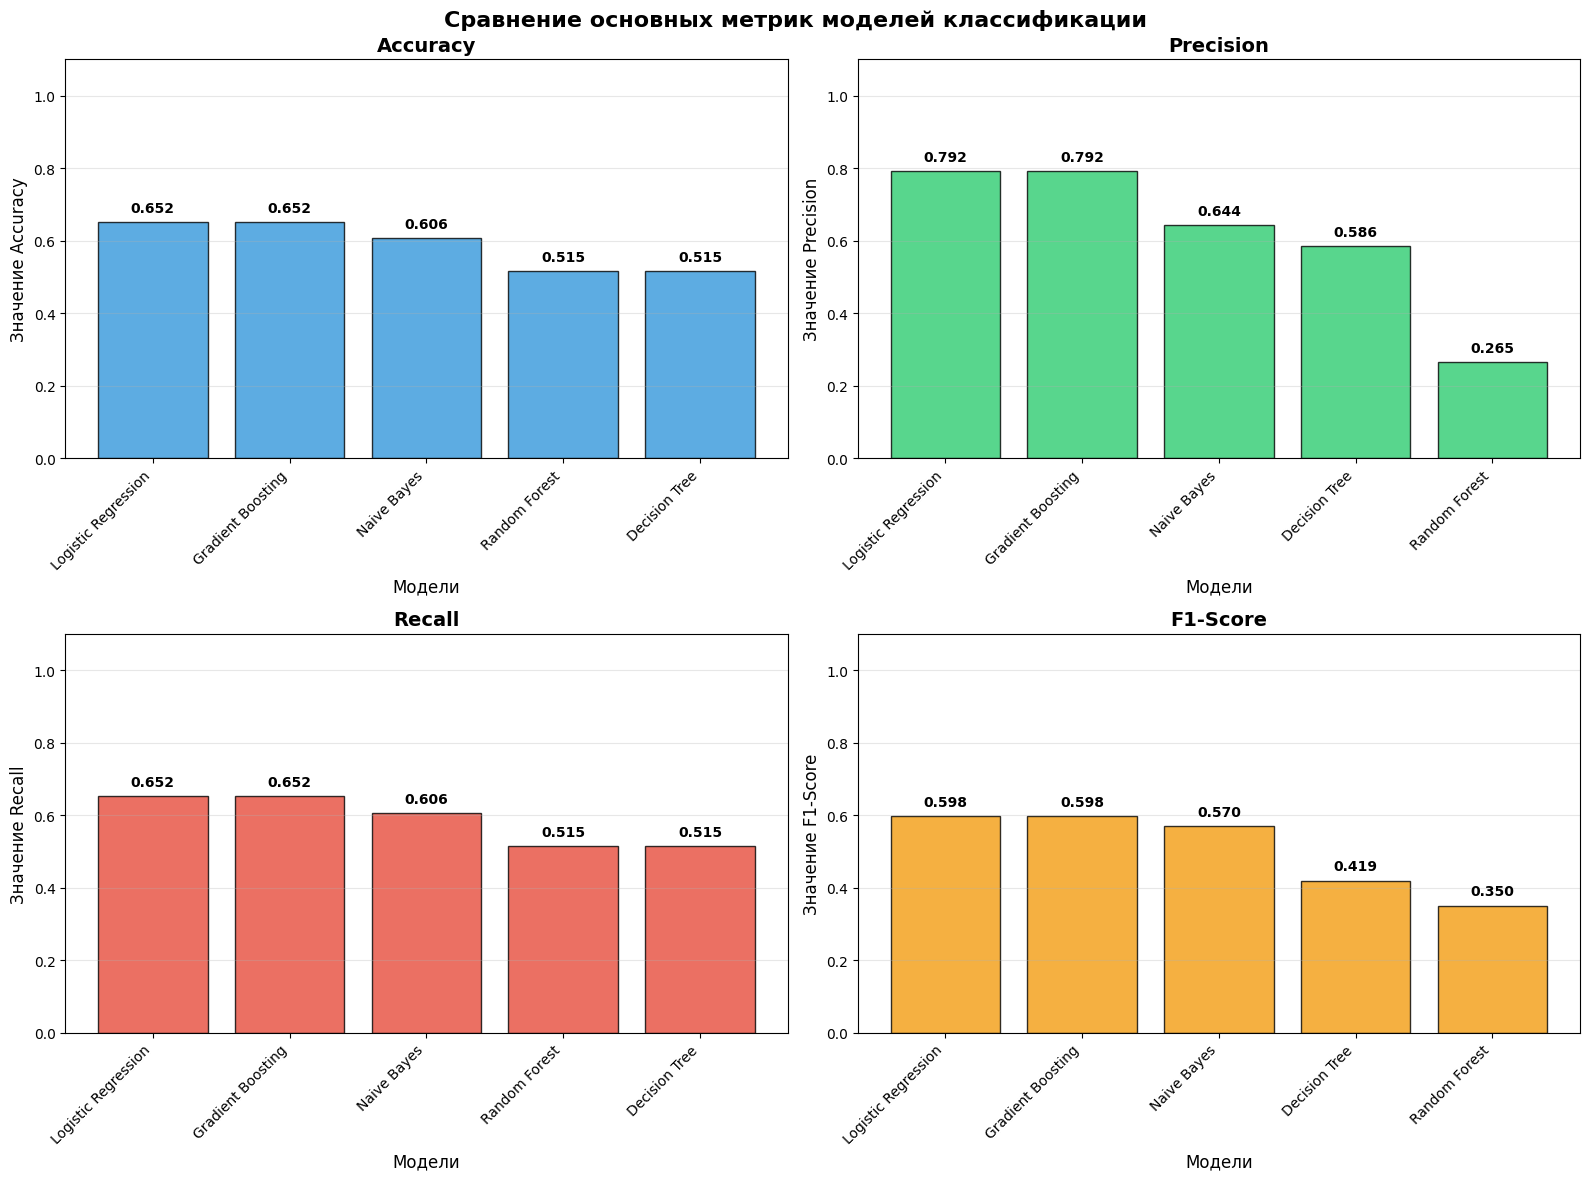

In [89]:
# ГРАФИК 1: СРАВНЕНИЕ ОСНОВНЫХ МЕТРИК
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Сравнение основных метрик моделей классификации', fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes1[idx // 2, idx % 2]
    
    # Сортируем по текущей метрике
    sorted_df = results_df_all.sort_values(metric, ascending=False)
    
    # Создаем столбчатую диаграмму
    bars = ax.bar(range(len(sorted_df)), sorted_df[metric], color=color, alpha=0.8, edgecolor='black')
    
    # Настройки графика
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
    ax.set_ylabel(f'Значение {metric}', fontsize=12)
    ax.set_xlabel('Модели', fontsize=12)
    ax.set_xticks(range(len(sorted_df)))
    ax.set_xticklabels(sorted_df['Model'], rotation=45, ha='right', fontsize=10)
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Добавляем значения на столбцы
    for i, (bar, value) in enumerate(zip(bars, sorted_df[metric])):
        if not pd.isna(value):
            height = bar.get_height()
            ax.text(i, height + 0.02, f'{value:.3f}', 
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

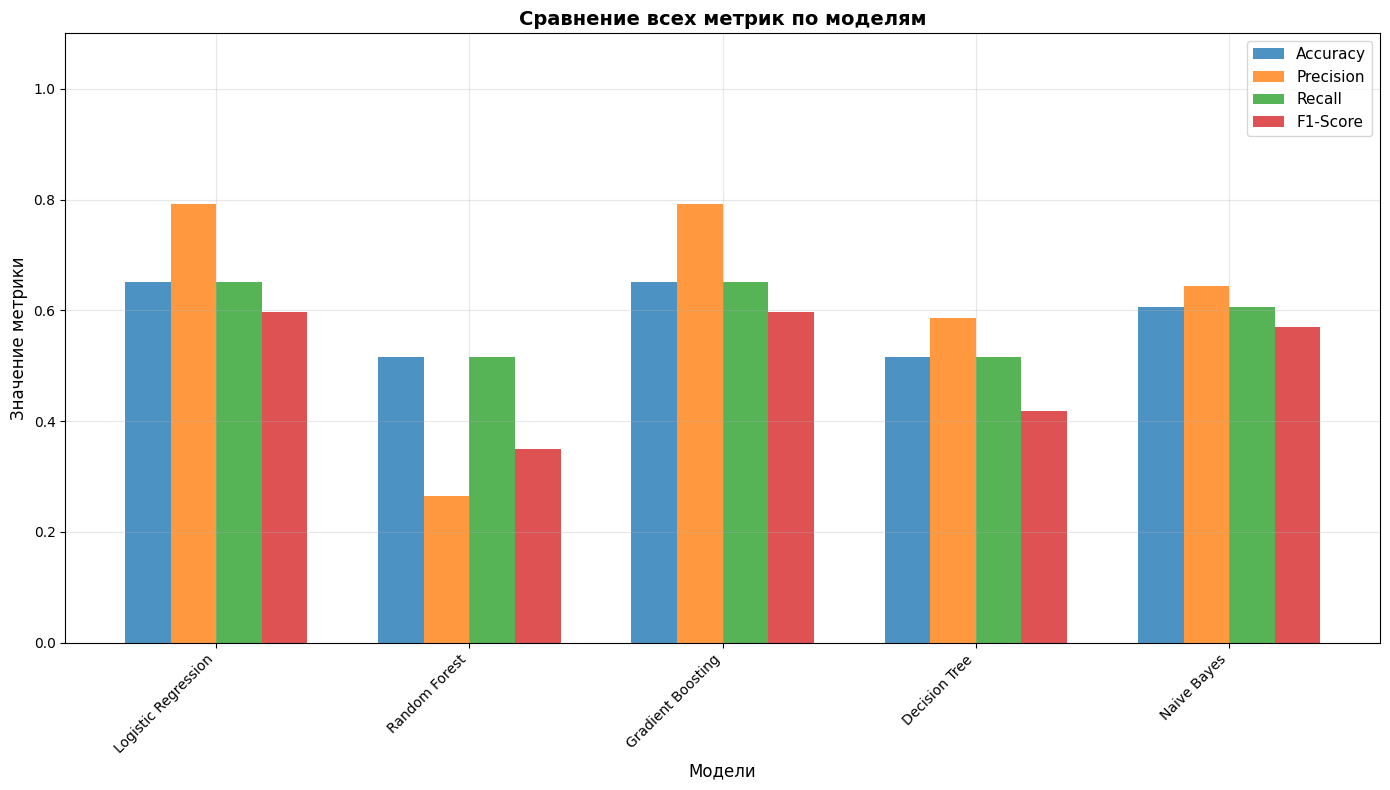

In [92]:
# ГРАФИК 2: СРАВНЕНИЕ ВСЕХ МЕТРИК НА ОДНОМ ГРАФИКЕ
fig_all, ax_all = plt.subplots(figsize=(14, 8))

# Подготовка данных
models = results_df_all['Model'].values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Количество моделей и метрик
n_models_all = len(models)
x = np.arange(n_models_all)
width = 0.18

# Создаем группированные столбцы
for i, metric in enumerate(metrics):
    values = results_df_all[metric].values
    ax_all.bar(x + i*width, values, width, label=metric, alpha=0.8)

ax_all.set_xlabel('Модели', fontsize=12)
ax_all.set_ylabel('Значение метрики', fontsize=12)
ax_all.set_title('Сравнение всех метрик по моделям', fontsize=14, fontweight='bold')
ax_all.set_xticks(x + width*1.5)
ax_all.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax_all.legend(fontsize=11)
ax_all.grid(True, alpha=0.3)
ax_all.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

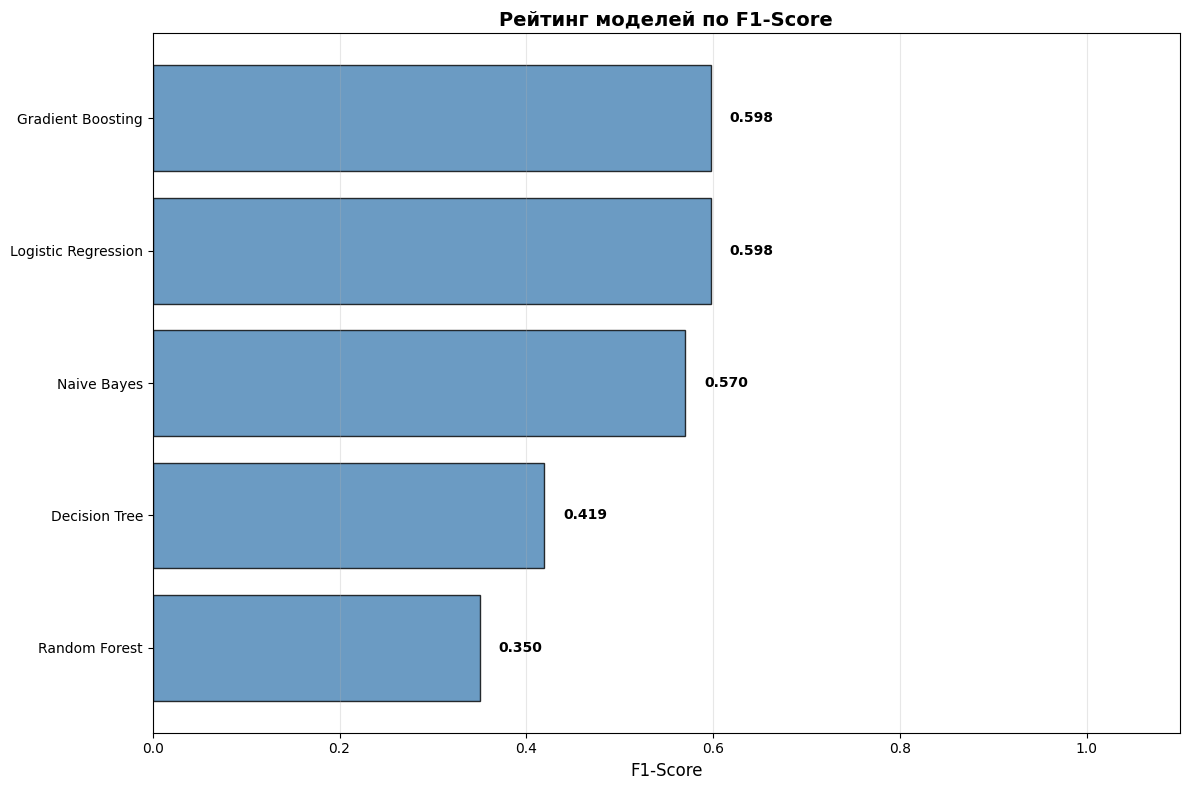

In [93]:
# ГРАФИК 3: РЕЙТИНГ МОДЕЛЕЙ ПО F1-SCORE
if 'F1-Score' in results_df_all.columns:
    # Сортируем по F1-Score
    sorted_by_f1 = results_df_all.sort_values('F1-Score', ascending=True)
    
    fig_f1, ax_f1 = plt.subplots(figsize=(12, 8))
    
    # Создаем горизонтальную столбчатую диаграмму
    bars = ax_f1.barh(range(len(sorted_by_f1)), sorted_by_f1['F1-Score'], 
                     color='steelblue', alpha=0.8, edgecolor='black')
    
    ax_f1.set_xlabel('F1-Score', fontsize=12)
    ax_f1.set_title('Рейтинг моделей по F1-Score', fontsize=14, fontweight='bold')
    ax_f1.set_yticks(range(len(sorted_by_f1)))
    ax_f1.set_yticklabels(sorted_by_f1['Model'], fontsize=10)
    ax_f1.set_xlim([0, 1.1])
    ax_f1.grid(True, alpha=0.3, axis='x')
    
    # Добавляем значения на столбцы
    for i, (bar, value) in enumerate(zip(bars, sorted_by_f1['F1-Score'])):
        if not pd.isna(value):
            width = bar.get_width()
            ax_f1.text(width + 0.02, i, f'{value:.3f}', 
                      va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("   F1-Score не рассчитан для моделей")

In [96]:
if len(results_df_all) > 0:
    # Определяем лучшую модель
    if 'F1-Score' in results_df_all.columns:
        best_model_idx = results_df_all['F1-Score'].idxmax()
        best_model = results_df_all.loc[best_model_idx]
        
        print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_model['Model']}")
        print("\n МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ:")
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
            if metric in best_model and not pd.isna(best_model[metric]):
                print(f"   • {metric}: {best_model[metric]:.4f}")


 ЛУЧШАЯ МОДЕЛЬ: Logistic Regression

 МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ:
   • Accuracy: 0.6515
   • Precision: 0.7921
   • Recall: 0.6515
   • F1-Score: 0.5978
